In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re
from numpy.random import seed
import nltk.stem
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)


ru_stemmer = nltk.stem.SnowballStemmer('russian')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([ru_stemmer.stem(w) for w in analyzer(doc)])



In [2]:
%%time
data_start=pd.read_pickle('data/WikiData_dat_5.pkl')
topic=[]
for row in data_start['cat'].tolist():
    if "спорт" in row:
        topic.append("sport")
    else:
        topic.append("other")
print (len(topic))
data_start['topic']=topic
data_bi=data_start[['title', 'cat', 'text2', 'noun', 'topic']][:3000]
data_test=data_start[['title', 'cat', 'text2', 'noun', 'topic']][3000:4000]
d_sport = (data_bi['topic']==u'sport')
data=data_bi.loc[d_sport]
print (len(data), len(data_test))


10748
117 1000
Wall time: 8.34 s


In [3]:
dfTimeUniqCat=pd.unique(data.topic.ravel())
print (len(dfTimeUniqCat))
category = data['topic'].tolist()
category = [str(i) for i in category]
#category = list(map(str, category))
content = data['title'].tolist()
stop_words = ['и']
content  = [str(x) for x in content]
for x in category:
    if not isinstance(x, str):
        print (x)


1


In [7]:
%%time
vectorizerContent = StemmedCountVectorizer (min_df=1, stop_words=stop_words, lowercase=True, analyzer="word")
vectorizerContent_2 = CountVectorizer (min_df=1, lowercase=True, analyzer="word", binary=True, ngram_range=(1, 1))
vectorizerCategory = CountVectorizer (min_df=1)

X = vectorizerContent.fit_transform(content)
X_2=vectorizerContent_2.fit_transform(content)
Xcat = vectorizerCategory.fit_transform(category)
xx = X.toarray().transpose()
xxcat = Xcat.toarray().transpose()

selected_feature_names_Cont = np.asarray(vectorizerContent.get_feature_names())
selected_feature_names_Cat = np.asarray(vectorizerCategory.get_feature_names())



Wall time: 63 ms


In [8]:
class OcTm (object):
    def __init__(self,  eta=1.0):
        self.eta=eta
        
    def fit(self, X, y):
        wordTopic=X.toarray().transpose() @ y
        self.ProbTopicWord = wordTopic.transpose()/np.sum(wordTopic, axis=1)
        ProbTopicDoc=X@self.ProbTopicWord.transpose()
        self.ProbTopicDoc=ProbTopicDoc.transpose()/np.sum(ProbTopicDoc, axis=1)
        return self
    
    def predict(self, query):
        predictMatrixW = []
        el_data= {}
        

        new_text_1=re.findall('\w+', query)
        new_text_2 = vectorizerContent_2.transform(new_text_1).toarray()
        penalty=(len(new_text_1)-sum(sum(new_text_2)))*self.eta
        self.new_text_1=new_text_1

        self.new_text_2=new_text_2
        self.penalty=penalty
        self.topicNewTest=np.dot(vectorizerContent.transform([query]).toarray(), self.ProbTopicWord.transpose())
        c=0
        for cat in selected_feature_names_Cat:
            self.topicNew=np.dot(self.ProbTopicWord[c], vectorizerContent.transform([query]).toarray().transpose())
            el_data[selected_feature_names_Cat[c]] = self.topicNew.sum()/(self.topicNewTest.sum()+penalty)
            c+=1
        el_data['other'] = penalty/(self.topicNewTest.sum()+penalty)
        self.el_data=el_data
        predictMatrixW.append(dict(el_data))
        dfMW = DataFrame(predictMatrixW)
        dfSumMW=dfMW.sum()
        i =0
        dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
        self.dfSumMW=dfSumMW
        for el in dfSumMW.T.iteritems():
            i += 1
            if i < 3:
                #return ("%s; %f" % (el[0], el[1]/dfSumMW.sum()))
                #resultat=el[1]/dfSumMW.sum()
                return (el[0], round(el[1], 2))



In [9]:
%%time
penalty=[0.99, 0.95, 0.9, 0.85, 0.8, 0.7, 0.5, 0.4]
score_p=[]
for v in penalty:
    i = 0
    outputpredict = []
    ot=OcTm(eta=v)
    ot.fit(X, Xcat)
    for query in data_test['title']:
        out=ot.predict(query)
        outputpredict.append(out[0])
        i+=1
    score = metrics.accuracy_score(data_test.topic.tolist(), outputpredict)
    score_p.append(score)
    print("accuracy:   %0.3f" % score)
    confmat=confusion_matrix(data_test.topic.tolist(), outputpredict)
    print (confmat)

    

accuracy:   0.936
[[924  45]
 [ 19  12]]
accuracy:   0.936
[[924  45]
 [ 19  12]]
accuracy:   0.936
[[924  45]
 [ 19  12]]
accuracy:   0.930
[[918  51]
 [ 19  12]]
accuracy:   0.923
[[910  59]
 [ 18  13]]
accuracy:   0.914
[[899  70]
 [ 16  15]]
accuracy:   0.813
[[793 176]
 [ 11  20]]
accuracy:   0.761
[[737 232]
 [  7  24]]
Wall time: 19.3 s


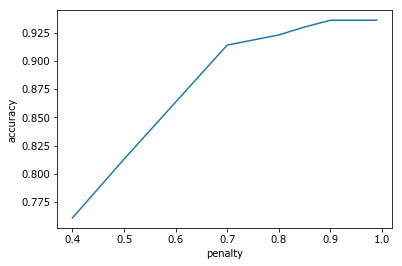

In [10]:
plt.figure()
plt.plot(penalty, score_p)
plt.ylabel('accuracy')
plt.xlabel('penalty')
plt.savefig('data/OC-TM.png')
plt.show()